# Delineate catchments for all gauges in Germany

In this script, we use the [Global Watersheds delineator](https://github.com/mheberger/delineator) to delineate catchments for all measuring stations in `metadata.csv`.  

This script is based on the steps from the tutorial provided on the [Global Watersheds delineator](https://github.com/mheberger/delineator) Github page.

cite Global Watersheds delineator: 10.5281/zenodo.7314287 

## 0. Install delineator

It seems to be important to have the right versions of all required packages to make delineate.py work.  
So before executing this script, create a new `venv`, activate it and then run `pip install -r merit_hydro/delineator/requirements.txt`

In [1]:
from camelsp import get_metadata, Station

import os
import requests
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd

/home/alexd/Projekte/CAMELS/Github/camelsp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alexd/Projekte/CAMELS/Github/camelsp/.venv/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/alexd/Projekte/CAMELS/Github/camelsp/.venv/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to

In [2]:
# create necessary directories
# folder for the downloaded data
datafolder = "../merit_hydro/data/"

# create the folder and subfolders if not exist
if not os.path.exists(datafolder):
    os.makedirs(datafolder)
    
    # folder for raster data
    os.makedirs(os.path.join(datafolder, "raster"))
    os.makedirs(os.path.join(datafolder, "raster", "accum_basins"))
    os.makedirs(os.path.join(datafolder, "raster", "flowdir_basins"))

    # folder for vector data
    os.makedirs(os.path.join(datafolder, "shp"))
    os.makedirs(os.path.join(datafolder, "shp", "merit_catchments"))
    os.makedirs(os.path.join(datafolder, "shp", "merit_rivers"))
    os.makedirs(os.path.join(datafolder, "shp", "catchments_simplified"))

## 1. Download MERIT-Hydro raster data

In [5]:
# download basin-scale MERIT-Hydro raster data (mghydro.com)
url_accum = ["https://mghydro.com/watersheds/rasters/accum_basins/accum22.tif",
             "https://mghydro.com/watersheds/rasters/accum_basins/accum23.tif",
             "https://mghydro.com/watersheds/rasters/accum_basins/accum24.tif"]

url_flow = ["https://mghydro.com/watersheds/rasters/flow_dir_basins/flowdir22.tif",
            "https://mghydro.com/watersheds/rasters/flow_dir_basins/flowdir23.tif",
            "https://mghydro.com/watersheds/rasters/flow_dir_basins/flowdir24.tif"]

# folder for the downloaded data
folder = "../merit_hydro/data/raster/"

for url in url_accum + url_flow:
    # download the file from the URL
    response = requests.get(url)

    if response.status_code == 200:
        # build the filename
        if url in url_accum:
            filename = os.path.join(folder, "accum_basins", os.path.basename(url))
        elif url in url_flow:
            filename = os.path.join(folder, "flowdir_basins", os.path.basename(url))
        
        # save the downloaded data to a file
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Data downloaded and saved to {filename}")
    else:
        print(f"Failed to download data. Status code: {response.status_code}")

Data downloaded and saved to ../merit_hydro/data/raster/accum_basins/accum22.tif
Data downloaded and saved to ../merit_hydro/data/raster/accum_basins/accum23.tif
Data downloaded and saved to ../merit_hydro/data/raster/accum_basins/accum24.tif
Data downloaded and saved to ../merit_hydro/data/raster/flowdir_basins/flowdir22.tif
Data downloaded and saved to ../merit_hydro/data/raster/flowdir_basins/flowdir23.tif
Data downloaded and saved to ../merit_hydro/data/raster/flowdir_basins/flowdir24.tif


## 2. Download MERIT-Basins vector data

Vector data is stored on Google Drive, so we download the data manually from https://www.reachhydro.org/home/params/merit-basins.

In the folder pfaf_level_02 , download two sets of files:

- unit catchment shapefiles: 
    - `cat_pfaf_22_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_catchments`  
    - `cat_pfaf_23_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_catchments`
    - `cat_pfaf_24_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_catchments`
- river flowline shapefiles: 
    - `riv_pfaf_22_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_rivers`
    - `riv_pfaf_23_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_rivers`
    - `riv_pfaf_24_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_rivers`

## 3. Download simplified MERIT-Basins data

In [6]:
url = "https://mghydro.com/watersheds/share/catchments_simplified.zip"

# folder for the downloaded data
folder = "../merit_hydro/data/shp/catchments_simplified/"

# download the file from the URL
response = requests.get(url)

if response.status_code == 200:
    # build the filename
    filename = os.path.join(folder, os.path.basename(url))

    # save the downloaded data to a file
    with open(filename, "wb") as file:
        file.write(response.content)
    print(f"Data downloaded and saved to {filename}")
else:
    print(f"Failed to download data. Status code: {response.status_code}")

# unzip
with zipfile.ZipFile(filename, 'r') as zip:
    zip.extractall(folder)

# remove zip file
os.remove(filename)

Data downloaded and saved to ../merit_hydro/data/shp/catchments_simplified/catchments_simplified.zip


## 4. Create a CSV file with your desired watershed outlet points

We create the watershed outlet points csv from `metadata.csv`.  

Required columns and mapping to camels metadata:
- `id` -> provider_id
- `lat` -> lat
- `lng` -> lon  

Optional columns:
- `name` -> gauge_name
- `area` -> area

In [3]:
# get CAMELS metadata
meta = get_metadata()

# select columns
outlets = meta[["camels_id", "lat", "lon", "gauge_name", "area"]].copy()

# rename columns
outlets.columns = ["id", "lat", "lng", "name", "area"]

# currently, not all rows are filled (e.g. some stations do not have lat and lon), remove those stations
outlets = outlets.dropna().reset_index(drop=True)

# drop lat and lon when infinity
outlets = outlets[(outlets["lat"] != np.inf) & (outlets["lng"] != np.inf)].reset_index(drop=True)

# replace -999.0 in column area with nan
outlets["area"] = outlets["area"].replace(-999.0, np.nan)

# save as csv
outlets.to_csv('../merit_hydro/data/outlets.csv', index=False)


## 5. Update config.py

This step can be omitted once the catchment delineation is set up.

## 6. Run delineator.py to delineate watersheds

In [4]:
# create output dir if not exist
if not os.path.exists("../merit_hydro/output"):
    os.makedirs("../merit_hydro/output")

# create plots dir if not exist
if not os.path.exists("../merit_hydro/delineator/plots"):
    os.makedirs("../merit_hydro/delineator/plots")

In [5]:
# takes around 15 mins for all stations
!cd ../merit_hydro && python delineate.py

/home/alexd/Projekte/CAMELS/Github/camelsp/.venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/alexd/Projekte/CAMELS/Github/camelsp/.venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
Created folder: map
Reading your outlets data in: data/outlets.csv
Finding out which Level 2 megabasin(s) your points are in
Your watershed outlets are in 3 basin(s)

Beginning delineation for 426 outlet point(s) in Level 2 Basin #22.
Reading geodata in data/shp/merit_catchments/cat_pfaf_22_MERIT_Hydro_v07_Basins_v01.shp
Reading data table for rivers in basin 22
Reading geodata in data/shp

## Save geojson to Station output folder

In [7]:
meta

,camels_id,provider_id,camels_path,nuts_lvl2,federal_state,gauge_name,waterbody_name,gauge_elevation,area,x,y,lon,lat,q_count,w_count,q_extent_years,w_extent_years
0,DEG10000,573000,./DEG/DEG10000/DEG10000_data.csv,DEG,Thüringen,Ammern,Unstrut,210.243,182.700,4.352221e+06,3.124617e+06,10.446993,51.231727,29646.0,29646.0,81.219178,32.186301
1,DEG10010,447000,./DEG/DEG10010/DEG10010_data.csv,DEG,Thüringen,Arenshausen,Leine,196.288,275.000,4.318941e+06,3.140875e+06,9.970428,51.378709,22707.0,22707.0,62.208219,59.876712
2,DEG10020,574200,./DEG/DEG10020/DEG10020_data.csv,DEG,Thüringen,Arnstadt,Gera,293.577,174.700,4.386764e+06,3.077926e+06,10.933022,50.809106,35490.0,35490.0,97.230137,32.186301
3,DEG10030,576500,./DEG/DEG10030/DEG10030_data.csv,DEG,Thüringen,Berga,Weiße Elster,218.995,1383.000,4.473276e+06,3.073272e+06,12.157989,50.750857,12845.0,12845.0,31.186301,35.189041
4,DEG10040,570210,./DEG/DEG10040/DEG10040_data.csv,DEG,Thüringen,Blankenstein-Rosenthal,Saale,410.517,1013.000,4.442190e+06,3.033884e+06,11.704738,50.404273,21246.0,21246.0,58.205479,52.032877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,DE112470,76273,./DE1/DE112470/DE112470_data.csv,DE1,Baden-Württemberg,Blaubeuren,Blautopf,511.871,0.067,4.304981e+06,2.811435e+06,9.783683,48.416174,30987.0,30987.0,65.380822,79.219178
2866,DE112480,76274,./DE1/DE112480/DE112480_data.csv,DE1,Baden-Württemberg,Erlenbach,Sulm,160.832,101.510,4.267341e+06,2.895499e+06,9.264333,49.170156,4140.0,4140.0,11.339726,11.339726
2867,DE112490,76276,./DE1/DE112490/DE112490_data.csv,DE1,Baden-Württemberg,Bolheim,Brenz,473.000,339.811,4.332390e+06,2.835208e+06,10.154468,48.630150,5555.0,5555.0,15.175342,15.216438
2868,DE112500,76290,./DE1/DE112500/DE112500_data.csv,DE1,Baden-Württemberg,Schweinhausen,Riß,541.098,101.589,4.305130e+06,2.769259e+06,9.787300,48.036705,8342.0,8342.0,22.852055,22.852055


In [8]:
# get metadata
outlets = pd.read_csv("../merit_hydro/data/outlets.csv")

# create a list of camels ids
camels_ids = meta["camels_id"].tolist()

for camels_id in camels_ids:
    try:
        # initiate Station
        s = Station(camels_id)

        # read geojson file
        gdf = gpd.read_file(f"../merit_hydro/output/{camels_id}.geojson")

        # save geojson to Station output folder
        s.save_catchment_geometry(gdf, datasource='merit_hydro')

    except Exception as e:
        print(f"{camels_id} --- Error: {e}")


DEF10750 --- Error: ../merit_hydro/output/DEF10750.geojson: No such file or directory
DEF11140 --- Error: ../merit_hydro/output/DEF11140.geojson: No such file or directory
DEF11150 --- Error: ../merit_hydro/output/DEF11150.geojson: No such file or directory
DEF11160 --- Error: ../merit_hydro/output/DEF11160.geojson: No such file or directory
DEF11170 --- Error: ../merit_hydro/output/DEF11170.geojson: No such file or directory
DEF11400 --- Error: ../merit_hydro/output/DEF11400.geojson: No such file or directory
DEF11680 --- Error: ../merit_hydro/output/DEF11680.geojson: No such file or directory
DEF11690 --- Error: ../merit_hydro/output/DEF11690.geojson: No such file or directory
DEF11700 --- Error: ../merit_hydro/output/DEF11700.geojson: No such file or directory
DEF12430 --- Error: ../merit_hydro/output/DEF12430.geojson: No such file or directory
DEF12570 --- Error: ../merit_hydro/output/DEF12570.geojson: No such file or directory
DEF12910 --- Error: ../merit_hydro/output/DEF12910.geo

# There is also the possibilty to use the API

This is less flexible as we cannot adapt parameters, put I didn't do that anyways, so I try it out.

In [31]:
import requests
from tqdm import tqdm
from camelsp import get_metadata, Station
import os

# get metadata
meta = get_metadata()

# create a list of camels ids
camels_ids = meta["camels_id"].tolist()

for camels_id in tqdm(camels_ids):
    # initiate Station
    s = Station(camels_id)

    # api url
    url = f"https://mghydro.com/app/watershed_api?lat={s.lat}&lng={s.lon}&precision=high"

    # get response
    response = requests.get(url)

     # If the status code is something else (400 or 404), there was a problem
    if response.status_code == 400 or response.status_code == 404:
        # There will usually be an error message explaining (briefly) what went wrong
        print(response.text)
        continue
    
    # 500 status code: (Internal Server Error) -> contact Mathew
    if response.status_code == 500:
        print("Server error. Please contact the developer.")
    
    # Status code of 200 means everything was OK!
    if response.status_code == 200:
        # build the filename
        fname = f"../merit_hydro/api_results/{s.camels_id}.geojson"
        
        # save the downloaded data to file
        with open(fname, 'w') as f:
            f.write(response.text)


  0%|          | 0/2870 [00:00<?, ?it/s]

 22%|██▏       | 642/2870 [17:17:30<60:00:33, 96.96s/it]


KeyboardInterrupt: 

In [36]:
import os
from camelsp import Station
import geopandas as gpd
import warnings

ids = [id[0:8] for id in os.listdir("../merit_hydro/api_results/")]

failed_ids = []

for id in ids:
    s = Station(id)

    if s.get_catchment(datasource="merit_hydro"):
        # read api catchment
        gdf_api = gpd.read_file(f"../merit_hydro/api_results/{id}.geojson")
        # read merit hydro
        gdf_merit = gpd.read_file(s.merit_hydro_path)

        # check if the api catchment is the same as the merit hydro catchment
        if gdf_api.geometry.geom_equals_exact(gdf_merit.geometry, tolerance=1).all():
            pass
        else:
            failed_ids.append(id)

print(f"Number of failed ids: {len(failed_ids)}")

Number of failed ids: 166


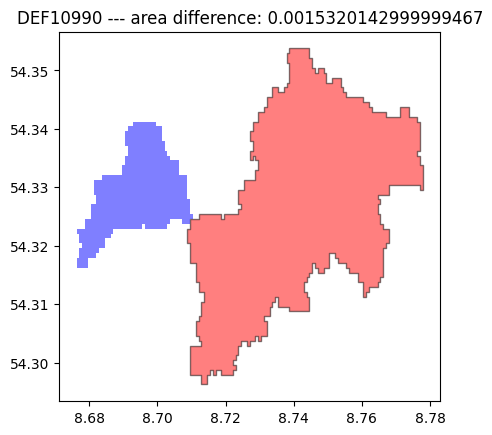

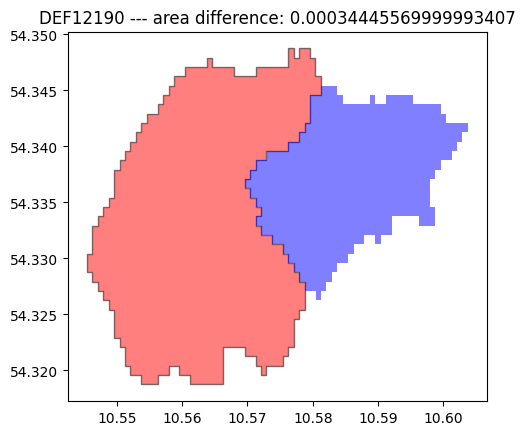

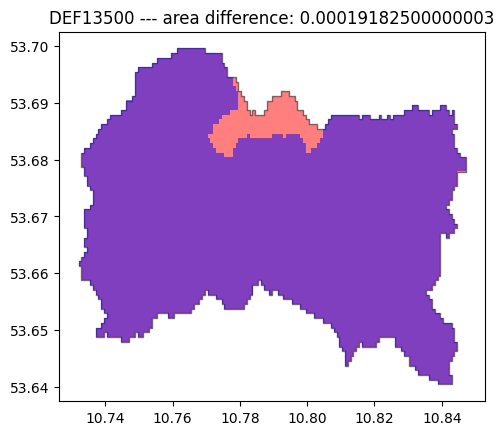

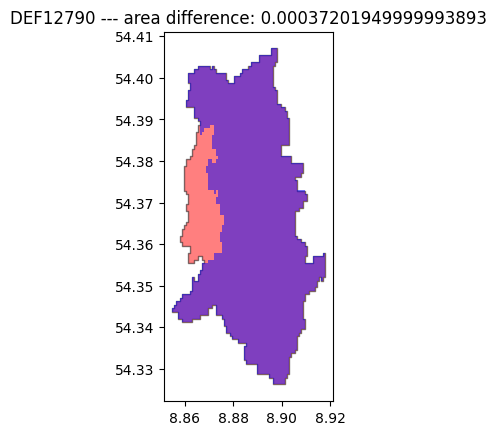

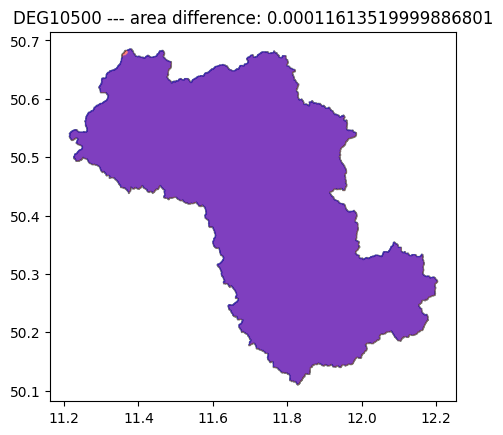

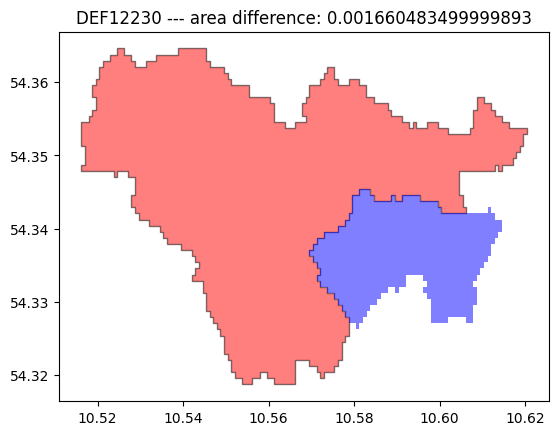

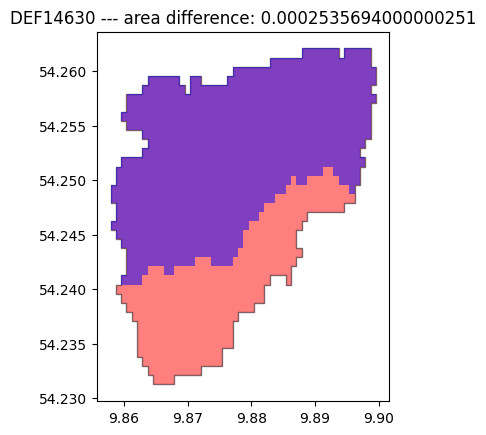

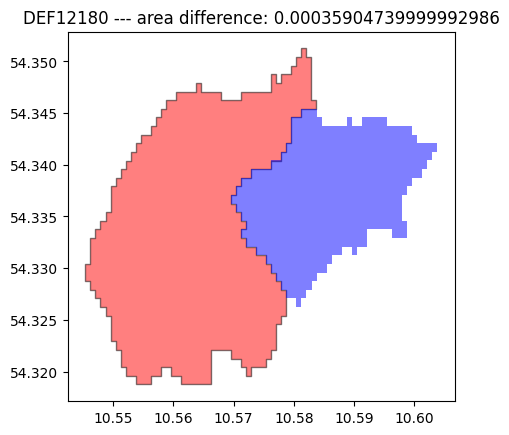

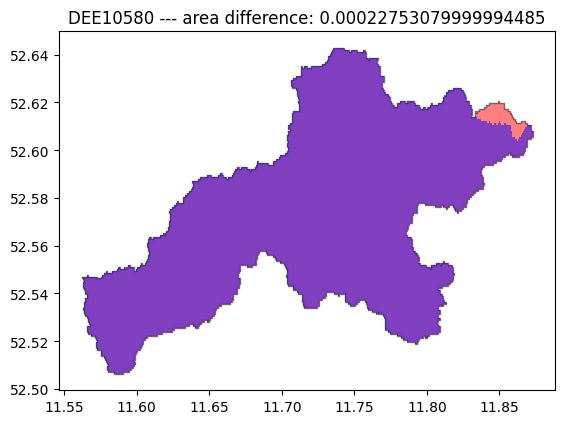

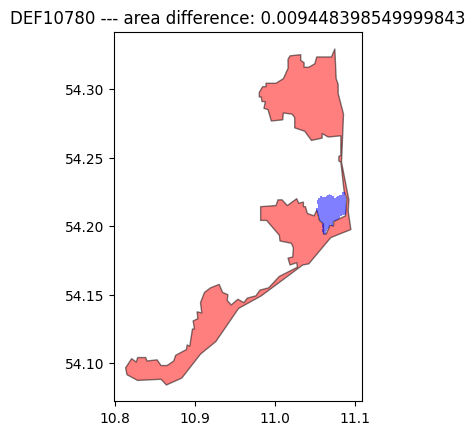

In [46]:
id = failed_ids[3]

for id in failed_ids:
    s = Station(id)

    # read api catchment
    gdf_api = gpd.read_file(f"../merit_hydro/api_results/{id}.geojson")
    # read merit hydro
    gdf_merit = s.get_catchment(datasource="merit_hydro")

    # calculate area difference
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        area_diff = gdf_api.area - gdf_merit.area
    if area_diff[0] > 0.0001:
        # plot both catchments
        ax = gdf_api.plot(color="red", edgecolor="black", alpha=0.5)
        gdf_merit.plot(ax=ax, color="blue", edgecolor="none", alpha=0.5)
        # add title
        ax.set_title(f"{id} --- area difference: {area_diff[0]}")


## API are results can be different!

Maybe we stick to the scrip method from Github...  
Even if the API is easier to use.